In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf

##### Preparing data for analysis

In [3]:
df = pd.read_csv(r"C:\Users\archi\OneDrive\Desktop\VU\My VU\P1\Adv Econ\Assignment GA - 2\dataset.csv", parse_dates = True).drop([0])
data = df[["sasdate","INDPRO","UNRATE"]].copy()
data["sasdate"] = pd.to_datetime(data["sasdate"], format = "%m-%d-%Y")
data = data.set_index(["sasdate"])
data = data.loc[:'2019-12-01']
data['INDPRO_d'] = data['INDPRO'].diff(1)
data['UNRATE_d'] = data['UNRATE'].diff(1)
data = data.dropna()
del df

In [4]:
data

,INDPRO,UNRATE,INDPRO_d,UNRATE_d
sasdate,,,,
1959-02-01,22.3917,5.9,0.4301,-0.1
1959-03-01,22.7142,5.6,0.3225,-0.3
1959-04-01,23.1981,5.2,0.4839,-0.4
1959-05-01,23.5476,5.1,0.3495,-0.1
1959-06-01,23.5744,5.0,0.0268,-0.1
...,...,...,...,...
2019-08-01,102.7814,3.6,0.7757,-0.1
2019-09-01,102.4601,3.5,-0.3213,-0.1
2019-10-01,101.5878,3.6,-0.8723,0.1


In [5]:
# defining loss functions

In [6]:
# AR(1)
def ar1_loss(data, mu, delta):
    loss = 0
    for i in range(len(data) - 1):
        predicted = mu + delta * data['UNRATE_d'].iloc[i]
        loss += (data['UNRATE_d'].iloc[i+1] - predicted) ** 2 
    return round(loss, 4)

In [7]:
# SESTAR Loss Function
def sestar_loss(data, mu, delta, gamma, alpha, beta):
    loss = 0
    for i in range(len(data) - 1):
        logistic_term = 1 / (1 + np.exp(alpha + beta * data['UNRATE_d'].iloc[i]))
        predicted = mu + (delta + gamma * logistic_term) * data['UNRATE_d'].iloc[i]
        loss += (data['UNRATE_d'].iloc[i+1] - predicted) ** 2
    return round(loss, 4)

In [8]:
# STAR Loss Function
def star_loss(data, mu, delta, gamma, alpha, beta):
    loss = 0
    for i in range(len(data) - 1):
        logistic_term = 1 / (1 + np.exp(alpha + beta * data['INDPRO_d'].iloc[i]))
        predicted = mu + (delta + gamma * logistic_term) * data['UNRATE_d'].iloc[i]
        loss += (data['UNRATE_d'].iloc[i+1] - predicted) ** 2
    return round(loss, 4)

In [9]:
def calculate_loss(model, data, mu, delta, gamma=None, alpha=None, beta=None):
    if model == 'AR':
        return ar1_loss(data, mu, delta)
    elif model == 'SESTAR':
        return sestar_loss(data, mu, delta, gamma, alpha, beta)
    elif model == 'STAR':
        return star_loss(data, mu, delta, gamma, alpha, beta)
    else:
        raise ValueError("Invalid model name. Please choose 'AR(1)', 'SESTAR', or 'STAR'.")

##### Question 2

In [11]:
mu = 0
delta = 0.1
gamma = 2
alpha = 0
beta = 3

print("AR(1):",calculate_loss('AR', data, mu, delta, gamma=gamma, alpha=alpha, beta=beta))
print("SESTAR:",calculate_loss('SESTAR', data, mu, delta, gamma=gamma, alpha=alpha, beta=beta))
print("STAR:",calculate_loss('STAR', data, mu, delta, gamma=gamma, alpha=alpha, beta=beta))

AR(1): 22.9222
SESTAR: 50.4604
STAR: 48.5205


##### Question 3

In [13]:
# AR(1)
def ar1_loss(params, data):
    mu, delta = params
    loss = 0
    for i in range(len(data) - 1):
        predicted = mu + delta * data['UNRATE_d'].iloc[i]
        loss += (data['UNRATE_d'].iloc[i+1] - predicted) ** 2
    return loss

In [14]:
initial_param = [0, 0.3]
result_ar = minimize(ar1_loss, initial_param, args=(data,), method='BFGS')
mu, delta = result_ar.x
#print(f"AR(1) Optimized Parameters:\nmu: {mu}\ndelta: {delta}")

In [15]:
# SESTAR
def sestar_loss(params, data):
    mu, delta, gamma, alpha, beta = params
    loss = 0
    for i in range(len(data) - 1):
        logistic_term = 1 / (1 + np.exp(alpha + beta * data['UNRATE_d'].iloc[i]))
        predicted = mu + (delta + gamma * logistic_term) * data['UNRATE_d'].iloc[i]
        loss += (data['UNRATE_d'].iloc[i+1] - predicted) ** 2
    return loss

In [16]:
initial_param = [0, 0.3, 0, 0, 6]
result_sestar = minimize(sestar_loss, initial_param, args=(data,), method='BFGS')
#print(f"SESTAR Optimized Parameters:\nmu: {mu}\ndelta: {delta}\ngamma: {gamma}\nalpha: {alpha}\nbeta: {beta}")

In [17]:
# STAR
def star_loss(params, data):
    mu, delta, gamma, alpha, beta = params
    loss = 0
    for i in range(len(data) - 1):
        logistic_term = 1 / (1 + np.exp(alpha + beta * data['INDPRO_d'].iloc[i]))
        predicted = mu + (delta + gamma * logistic_term) * data['UNRATE_d'].iloc[i]
        loss += (data['UNRATE_d'].iloc[i+1] - predicted) ** 2
    return loss

In [18]:
initial_param = [0, 0.3, 0, 0, 6]
result_star = minimize(star_loss, initial_param, args=(data,), method='BFGS')
#print("SESTAR Optimized Parameters:", result_sestar.x)

In [19]:
def print_params(model_name, result, param_names):
    print(f"{model_name} Optimized Parameters:")
    for name, value in zip(param_names, result.x):
        print(f"{name}: {value}")

# Usage for AR(1)
print_params('AR(1)', result_ar, ['mu', 'delta'])
print("")

# Usage for SESTAR
print_params('SESTAR', result_sestar, ['mu', 'delta', 'gamma', 'alpha', 'beta'])
print("")
# Usage for STAR
print_params('STAR', result_star, ['mu', 'delta', 'gamma', 'alpha', 'beta'])


AR(1) Optimized Parameters:
mu: -0.00278351276470817
delta: 0.1116847802389619

SESTAR Optimized Parameters:
mu: -0.02231250016598466
delta: 0.42942376902622587
gamma: -0.5459252255377902
alpha: -6.154730768776679
beta: 28.57153434410199

STAR Optimized Parameters:
mu: -0.014452667389389733
delta: -0.07531064588928799
gamma: 1.0202296782375955
alpha: 3.3671256907742895
beta: 5.276831835104761


In [20]:
# Functions for Fitted values

In [21]:
def fitted_ar1(mu, delta, data):
    fitted_values = []
    for i in range(len(data) - 1):
        predicted = mu + delta * data['UNRATE'].iloc[i]
        fitted_values.append(predicted)
    return fitted_values

def fitted_sestar(mu, delta, gamma, alpha, beta, data):
    fitted_values = []
    for i in range(len(data) - 1):
        logistic_term = 1 / (1 + np.exp(alpha + beta * data['UNRATE'].iloc[i]))
        predicted = mu + (delta + gamma * logistic_term) * data['UNRATE'].iloc[i]
        fitted_values.append(predicted)
    return fitted_values

def fitted_star(mu, delta, gamma, alpha, beta, data):
    fitted_values = []
    for i in range(len(data) - 1):
        logistic_term = 1 / (1 + np.exp(alpha + beta * data['INDPRO'].iloc[i]))
        predicted = mu + (delta + gamma * logistic_term) * data['UNRATE'].iloc[i]
        fitted_values.append(predicted)
    return fitted_values

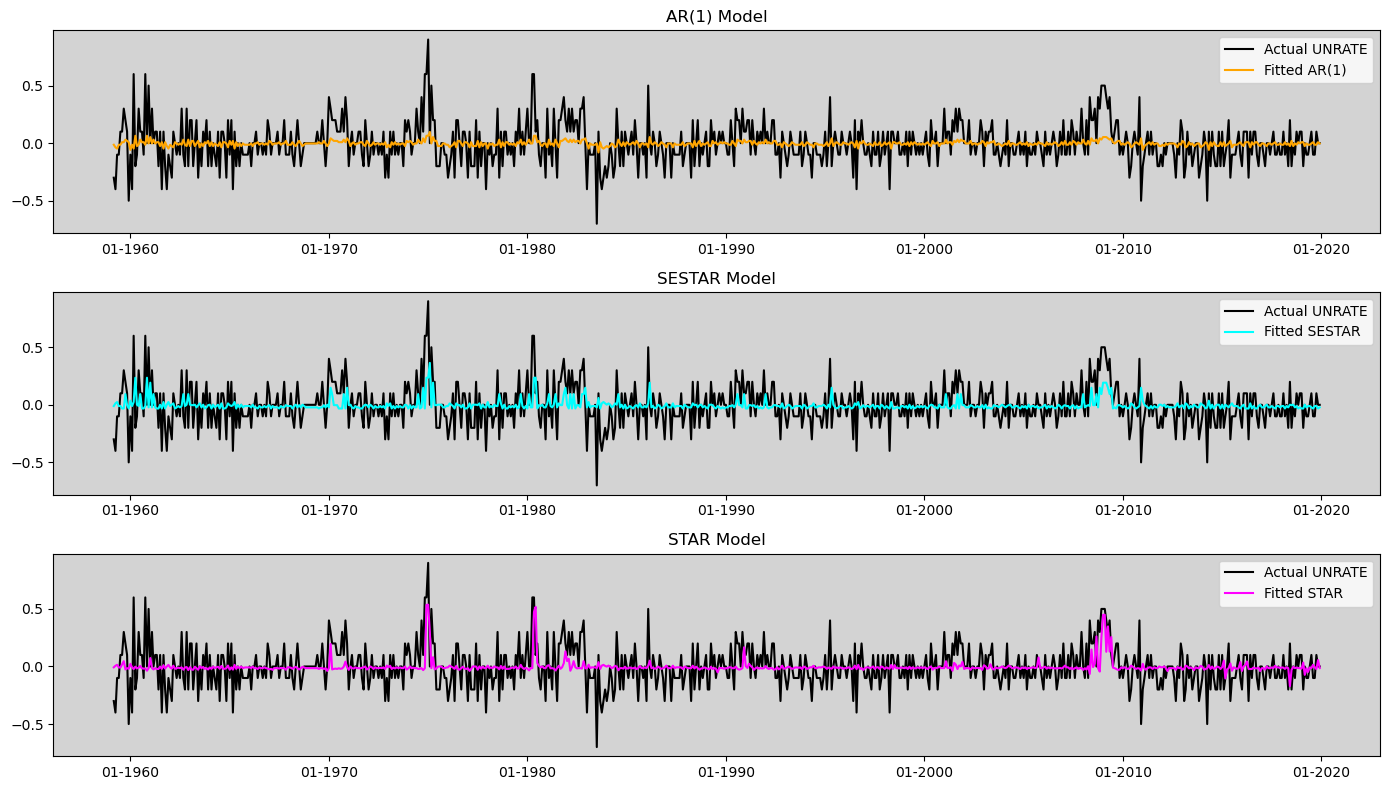

In [24]:
def fitted_ar1(mu, delta, data):
    fitted_values = []
    for i in range(len(data) - 1):
        predicted = mu + delta * data['UNRATE_d'].iloc[i]
        fitted_values.append(predicted)
    return fitted_values

def fitted_sestar(mu, delta, gamma, alpha, beta, data):
    fitted_values = []
    for i in range(len(data) - 1):
        logistic_term = 1 / (1 + np.exp(alpha + beta * data['UNRATE_d'].iloc[i]))
        predicted = mu + (delta + gamma * logistic_term) * data['UNRATE_d'].iloc[i]
        fitted_values.append(predicted)
    return fitted_values

def fitted_star(mu, delta, gamma, alpha, beta, data):
    fitted_values = []
    for i in range(len(data) - 1):
        logistic_term = 1 / (1 + np.exp(alpha + beta * data['INDPRO_d'].iloc[i]))
        predicted = mu + (delta + gamma * logistic_term) * data['UNRATE_d'].iloc[i]
        fitted_values.append(predicted)
    return fitted_values


# AR(1) Optimized Parameters
mu_ar, delta_ar = -0.00278351276470817, 0.1116847802389619

# SESTAR Optimized Parameters
mu_sestar, delta_sestar, gamma_sestar, alpha_sestar, beta_sestar = (
    -0.02231250016598466, 0.4294237690622587, -0.5459252255377902, -6.154730768776679, 28.57153434410199
)

# STAR Optimized Parameters
mu_star, delta_star, gamma_star, alpha_star, beta_star = (
    -0.014452667389893733, -0.07531064588928799, 1.002296782375955, 3.3671256907748295, 5.276831835104761
)

# Generate fitted values using the fitted functions
fitted_values_ar = fitted_ar1(mu_ar, delta_ar, data)
fitted_values_sestar = fitted_sestar(mu_sestar, delta_sestar, gamma_sestar, alpha_sestar, beta_sestar, data)
fitted_values_star = fitted_star(mu_star, delta_star, gamma_star, alpha_star, beta_star, data)

# Create 3-panel plot
plt.figure(figsize=(14, 8))

# AR(1) Plot
plt.subplot(3, 1, 1)
plt.plot(data.index[1:], data['UNRATE_d'][1:], label='Actual UNRATE', color='black')
plt.plot(data.index[1:], fitted_values_ar, label='Fitted AR(1)', color='orange')
plt.title('AR(1) Model')
plt.legend()
plt.gca().set_facecolor('lightgray')  # Set background color to gray
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))  # Show month and year

# SESTAR Plot
plt.subplot(3, 1, 2)
plt.plot(data.index[1:], data['UNRATE_d'][1:], label='Actual UNRATE', color='black')
plt.plot(data.index[1:], fitted_values_sestar, label='Fitted SESTAR', color='cyan')
plt.title('SESTAR Model')
plt.legend()
plt.gca().set_facecolor('lightgray')  # Set background color to gray
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))  # Show month and year

# STAR Plot
plt.subplot(3, 1, 3)
plt.plot(data.index[1:], data['UNRATE_d'][1:], label='Actual UNRATE', color='black')
plt.plot(data.index[1:], fitted_values_star, label='Fitted STAR', color='magenta')
plt.title('STAR Model')
plt.legend()
plt.gca().set_facecolor('lightgray')  # Set background color to gray
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y')) # Show month and year

# Show the plot
plt.tight_layout()
plt.show()


In examining the three periods of interest—November 1973 to March 1975, January 1980 to July 1980, and December 2007 to June 2009—it becomes clear that each model responds differently to economic shocks.

The AR(1) model provides a basic linear relationship based on previous unemployment, leading to a relatively smooth fit. It fails to capture the sharp spikes in unemployment during the recessions, particularly in the Great Recession (2007-2009), where the model smooths over the volatility, underestimating the sudden shifts in the unemployment rate.

The SESTAR model introduces non-linearity, allowing for regime switching. This results in a better fit during periods of economic instability. For example, during the 1973-1975 and 1980 recessions, the SESTAR model captures some fluctuations, but it still struggles to fully reflect the magnitude of volatility during extreme periods.

The STAR model, with its more complex non-linear structure, fits the data the best, particularly during high-volatility periods like the Great Recession. It captures sudden changes in unemployment far better than both the AR(1) and SESTAR models, especially in 2008. However, this model may slightly overfit the data during more stable periods.

In conclusion, the AR(1) model provides a smoother fit, while SESTAR and STAR models progressively improve the fit during periods of significant economic stress.








R-Squared Values:
    Model       R^2  Adjusted R^2
0   AR(1)  0.012479      0.011122
1  SESTAR  0.062161      0.056987
2    STAR  0.102485      0.097533


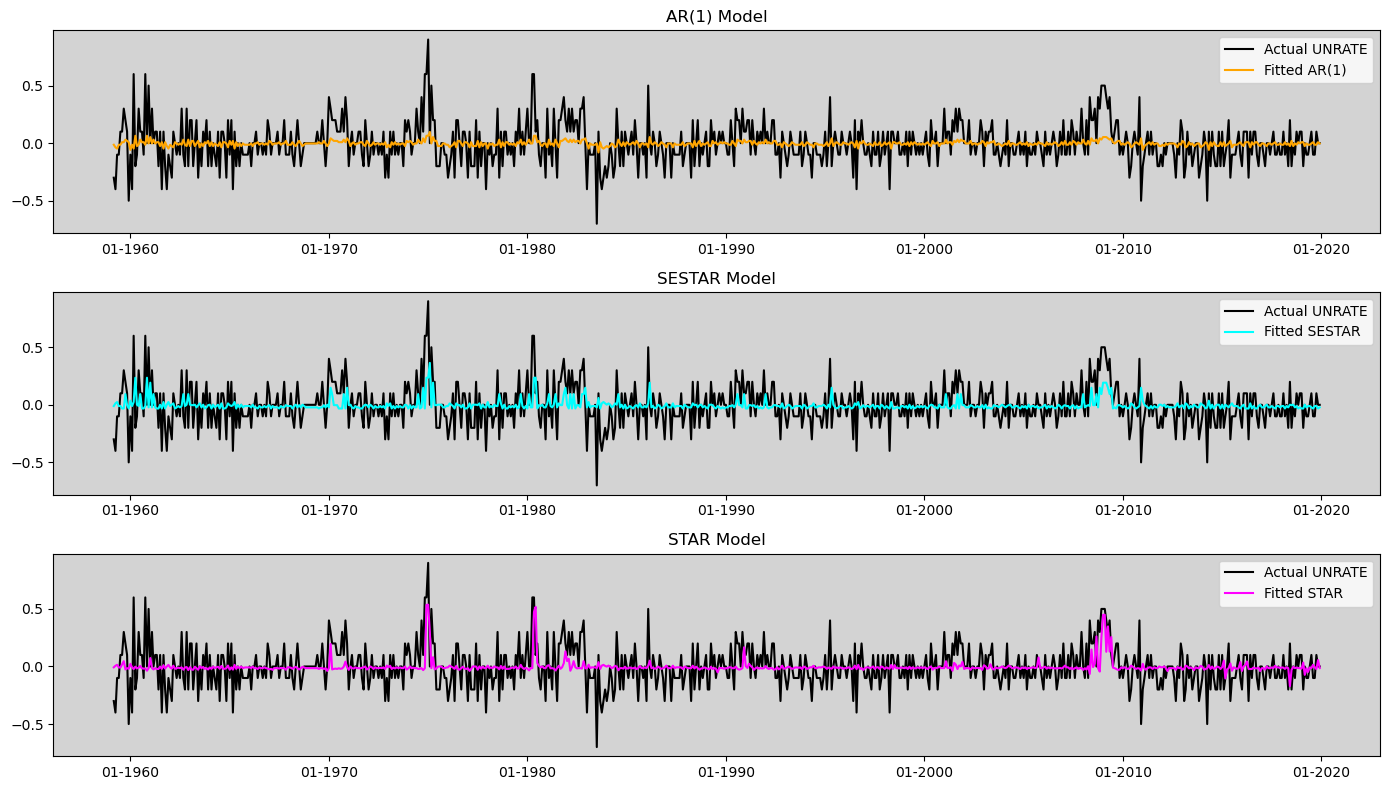

In [78]:

def fitted_ar1(mu, delta, data):
    fitted_values = []
    for i in range(len(data) - 1):
        predicted = mu + delta * data['UNRATE_d'].iloc[i]
        fitted_values.append(predicted)
    return fitted_values

def fitted_sestar(mu, delta, gamma, alpha, beta, data):
    fitted_values = []
    for i in range(len(data) - 1):
        logistic_term = 1 / (1 + np.exp(alpha + beta * data['UNRATE_d'].iloc[i]))
        predicted = mu + (delta + gamma * logistic_term) * data['UNRATE_d'].iloc[i]
        fitted_values.append(predicted)
    return fitted_values

def fitted_star(mu, delta, gamma, alpha, beta, data):
    fitted_values = []
    for i in range(len(data) - 1):
        logistic_term = 1 / (1 + np.exp(alpha + beta * data['INDPRO_d'].iloc[i]))
        predicted = mu + (delta + gamma * logistic_term) * data['UNRATE_d'].iloc[i]
        fitted_values.append(predicted)
    return fitted_values


def calculate_r_squared(actual, fitted):
    ss_res = np.sum((actual - fitted) ** 2)
    ss_tot = np.sum((actual - np.mean(actual)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

def calculate_adjusted_r_squared(r_squared, n, p):
    adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))
    return adjusted_r_squared


mu_ar, delta_ar = -0.00278351276470817, 0.1116847802389619


mu_sestar, delta_sestar, gamma_sestar, alpha_sestar, beta_sestar = (
    -0.02231250016598466, 0.4294237690622587, -0.5459252255377902, -6.154730768776679, 28.57153434410199
)


mu_star, delta_star, gamma_star, alpha_star, beta_star = (
    -0.014452667389893733, -0.07531064588928799, 1.002296782375955, 3.3671256907748295, 5.276831835104761
)


fitted_values_ar = fitted_ar1(mu_ar, delta_ar, data)
fitted_values_sestar = fitted_sestar(mu_sestar, delta_sestar, gamma_sestar, alpha_sestar, beta_sestar, data)
fitted_values_star = fitted_star(mu_star, delta_star, gamma_star, alpha_star, beta_star, data)


fitted_values_ar = np.array(fitted_values_ar)
fitted_values_sestar = np.array(fitted_values_sestar)
fitted_values_star = np.array(fitted_values_star)


n = len(data['UNRATE_d']) - 1 
p_ar = 1
p_sestar = 4 
p_star = 4

r_squared_ar = calculate_r_squared(data['UNRATE_d'][1:], fitted_values_ar)
adj_r_squared_ar = calculate_adjusted_r_squared(r_squared_ar, n, p_ar)

r_squared_sestar = calculate_r_squared(data['UNRATE_d'][1:], fitted_values_sestar)
adj_r_squared_sestar = calculate_adjusted_r_squared(r_squared_sestar, n, p_sestar)

r_squared_star = calculate_r_squared(data['UNRATE_d'][1:], fitted_values_star)
adj_r_squared_star = calculate_adjusted_r_squared(r_squared_star, n, p_star)


results_df = pd.DataFrame({
    'Model': ['AR(1)', 'SESTAR', 'STAR'],
    'R^2': [r_squared_ar, r_squared_sestar, r_squared_star],
    'Adjusted R^2': [adj_r_squared_ar, adj_r_squared_sestar, adj_r_squared_star]
})

print("R-Squared Values:")
print(results_df)


plt.figure(figsize=(14, 8))
plt.subplot(3, 1, 1)
plt.plot(data.index[1:], data['UNRATE_d'][1:], label='Actual UNRATE', color='black')
plt.plot(data.index[1:], fitted_values_ar, label='Fitted AR(1)', color='orange')
plt.title('AR(1) Model')
plt.legend()
plt.gca().set_facecolor('lightgray')  
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))  


plt.subplot(3, 1, 2)
plt.plot(data.index[1:], data['UNRATE_d'][1:], label='Actual UNRATE', color='black')
plt.plot(data.index[1:], fitted_values_sestar, label='Fitted SESTAR', color='cyan')
plt.title('SESTAR Model')
plt.legend()
plt.gca().set_facecolor('lightgray')  
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))


plt.subplot(3, 1, 3)
plt.plot(data.index[1:], data['UNRATE_d'][1:], label='Actual UNRATE', color='black')
plt.plot(data.index[1:], fitted_values_star, label='Fitted STAR', color='magenta')
plt.title('STAR Model')
plt.legend()
plt.gca().set_facecolor('lightgray') 
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.tight_layout()
plt.show()


#### Question 4

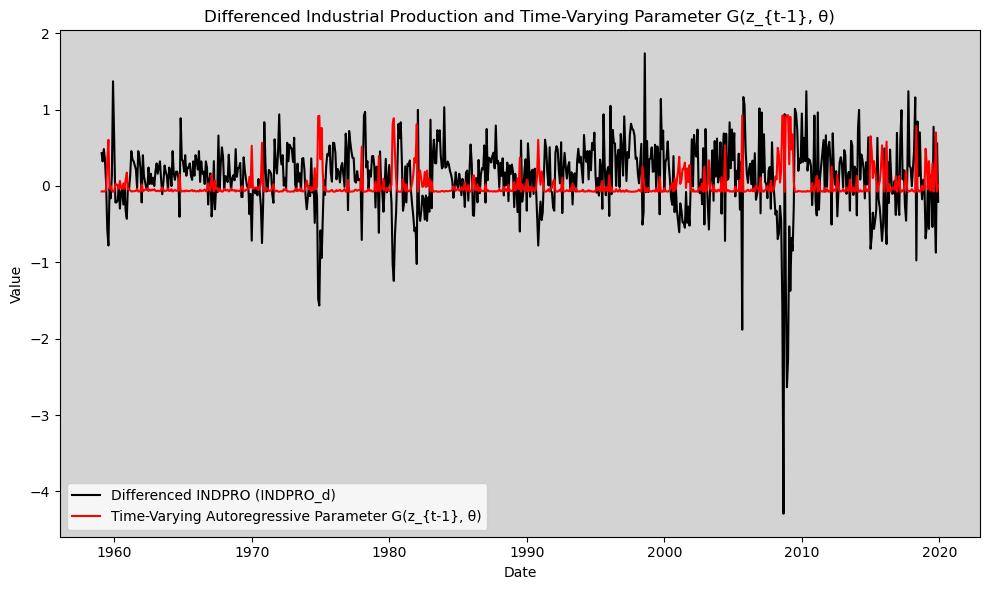

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# STAR Optimized Parameters
mu_star, delta_star, gamma_star, alpha_star, beta_star = (
    -0.014452667389893733, -0.07531064588928799, 1.002296782375955, 
    3.3671256907748295, 5.276831835104761
)

# Function to compute G(z_t-1, θ) for the STAR model
def G_star(INDPRO_d, delta, gamma, alpha, beta):
    G_values = []
    for z_t_1 in INDPRO_d:
        logistic_term = 1 / (1 + np.exp(alpha + beta * z_t_1))
        G = delta + gamma * logistic_term
        G_values.append(G)
    return G_values

# Calculate G(z_{t-1}, θ)
G_values = G_star(data['INDPRO_d'], delta_star, gamma_star, alpha_star, beta_star)

# Plot the values of INDPRO_d and G(z_{t-1}, θ) in a single line plot
plt.figure(figsize=(10, 6))

plt.plot(data.index, data['INDPRO_d'], label='Differenced INDPRO (INDPRO_d)', color='black')
plt.plot(data.index, G_values, label='Time-Varying Autoregressive Parameter G(z_{t-1}, θ)', color='red')

plt.title('Differenced Industrial Production and Time-Varying Parameter G(z_{t-1}, θ)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.gca().set_facecolor('lightgray')
plt.legend()

plt.tight_layout()
plt.show()


The relationship between the persistence in unemployment rates and industrial production reflects the dynamics of economic cycles. Industrial production tends to be more volatile, reacting quickly to changes in economic conditions, such as demand, investment, and business cycles. On the other hand, unemployment rates typically adjust more slowly, reflecting persistence. This persistence is due to structural factors in the labor market—such as contracts, hiring and firing costs, and policy responses—that cause delays in employment adjustments to economic shocks.

Economic theory supports this observation. During a downturn, industrial production may decline sharply as firms reduce output in response to lower demand. However, firms may delay laying off workers due to costs or expectations of recovery, leading to a slower increase in unemployment. Similarly, during an expansion, production may rise quickly, but hiring lags behind as firms take time to assess the sustainability of the growth.

This persistence in unemployment is consistent with the time-varying autoregressive parameter \( G(z_{t-1}, \theta) \) seen in the STAR model plot. The smooth changes in \( G \) suggest that the economy transitions gradually between states, while industrial production experiences more frequent and sharper changes, aligning with observed economic cycles.

---------------------------------------------------------------------------------------------------------------------------------------------

The plot displays the relationship between the differenced industrial production index (INDPRO) and the time-varying autoregressive parameter \( G(z_{t-1}, \theta) \), which is modeled using a STAR (Smooth Transition Autoregressive) model. The black line represents the differenced values of industrial production, while the red line shows the estimated time-varying autoregressive parameter.

The black line for industrial production fluctuations demonstrates volatility, especially around economic downturns, such as the 2008 financial crisis, indicated by a sharp drop. In contrast, the red line (the autoregressive parameter) remains relatively stable, reflecting its role in smoothing the transition between different regimes. The smoothness of the red line suggests that while industrial production may exhibit high-frequency fluctuations, the STAR model's parameter adapts gradually, providing persistence and capturing the non-linear dynamics of the underlying economic processes.

This persistence in the autoregressive parameter reflects the idea that industrial production tends to exhibit prolonged deviations during economic shocks, gradually returning to equilibrium. Economic theory would suggest that this model captures the non-linearities inherent in industrial production cycles. For example, in times of recession, recovery tends to occur slowly as production factors adjust, explaining the more gradual shifts in the red line. This relationship is crucial in understanding business cycles and policy interventions aimed at stabilizing output.

#### Question 5

In [29]:
residuals = data['UNRATE_d'][1:].copy() - fitted_values_star

In [30]:
residuals

sasdate
1959-03-01   -0.292722
1959-04-01   -0.406261
1959-05-01   -0.114599
1959-06-01   -0.092535
1959-07-01    0.109835
                ...   
2019-08-01   -0.115047
2019-09-01   -0.093021
2019-10-01    0.122778
2019-11-01   -0.055678
2019-12-01    0.014453
Name: UNRATE_d, Length: 730, dtype: float64

<Figure size 1000x600 with 0 Axes>

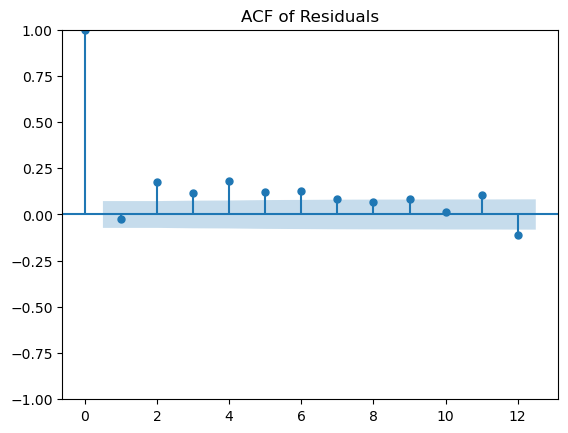

In [31]:
plt.figure(figsize=(10, 6))
plot_acf(residuals, lags=12)  # lags=12 for the first 12 lags
plt.title('ACF of Residuals')
plt.show()

Given that there are no significant autocorrelations at higher lags (beyond lag 0), we can conclude that the SESTAR model appears to be correctly specified. The absence of significant autocorrelation in the residuals implies that the model has adequately captured the relationship between the unemployment rate and the other variables without leaving systematic patterns in the residuals.

In a correctly specified model, the residuals should behave like white noise, meaning they are uncorrelated with each other. Since the residuals in the ACF plot show no significant autocorrelation at higher lags, this indicates that the model does not suffer from issues like underfitting or omitted variable bias. Therefore, based on the ACF plot, the SESTAR model seems to be appropriately capturing the dynamics of the unemployment rate.

#### Question 6

In [34]:
## SESTAR

In [58]:
import numpy as np
import pandas as pd

# Define the gradient function for the AR(1) model
def grad_ar1(params, x, lag_x):
    mu, delta = params
    residuals = x - (mu + delta * lag_x)
    grad_mu = -2 * residuals
    grad_delta = -2 * residuals * lag_x
    return np.vstack((grad_mu, grad_delta)).T  # Return gradients as (T x 2) matrix

# Define function to compute Σ_j (lagged covariance)
def compute_sigma_j(gradients, j, T):
    sigma_j = np.zeros((gradients.shape[1], gradients.shape[1]))  # Initialize Σ_j (2x2 matrix)
    for t in range(j + 2, T):
        G_t = gradients[t]
        G_tj = gradients[t - j]
        sigma_j += np.outer(G_t, G_tj)  # Compute outer product G_t * G_{t-j}'
    sigma_j /= T
    return sigma_j

# Define function to compute Newey-West variance estimator
def newey_west(gradients, T, p):
    # Σ_0 (no lags)
    sigma_0 = compute_sigma_j(gradients, 0, T)
    
    # Initialize Σ (starting with Σ_0)
    sigma = sigma_0.copy()

    # Compute Σ_j + Σ_j' for each lag j from 1 to p
    for j in range(1, p + 1):
        sigma_j = compute_sigma_j(gradients, j, T)
        weight = 1 - (j / (p + 1))  # Weight for Newey-West estimator
        sigma += weight * (sigma_j + sigma_j.T)  # Σ_j + Σ_j' with weight

    return sigma

# Load your dataset
#data = pd.read_csv('your_data.csv', parse_dates=['sasdate'], index_col='sasdate')

# Extract the relevant columns (first differences for AR(1))
x = data['UNRATE_d'].values  # x_t (unemployment rate differences)
lag_x = np.roll(x, 1)  # x_{t-1} (lagged unemployment rate differences)

# Remove the first observation due to lagging
x, lag_x = x[1:], lag_x[1:]

# AR(1) optimized parameters
ar1_params = [-0.00278351276470817, 0.1116847802389619]

# Calculate the gradient matrix for the AR(1) model
gradients = grad_ar1(ar1_params, x, lag_x)

# Compute the Newey-West variance estimator
T = len(x)  # Number of observations
p = 12  # Number of lags to consider for the Newey-West estimator
nw_variance_ar1 = newey_west(gradients, T, p)

# Extract standard errors (square root of diagonal elements)
se_ar1 = np.sqrt(np.diag(nw_variance_ar1))

# Display the results
print("Newey-West Variance-Covariance Matrix (AR(1)):\n", nw_variance_ar1)
print("\nAR(1) Robust Standard Errors:", se_ar1)


Newey-West Variance-Covariance Matrix (AR(1)):
 [[0.2917007  0.04396945]
 [0.04396945 0.01716581]]

AR(1) Robust Standard Errors: [0.54009324 0.13101835]
